# Applying Reinforcement learning on Blackjack (Twenty one)

In [21]:
import pandas as pd
from copy import deepcopy
import random
from matplotlib import cm

import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

## Implemented criteria for RL
* Winning round equals one point
* losing round equals -ve one point 
* Draw round eqauls zero point

In [22]:
class Twenty_one():

  def __init__(self):
  
    casino_point, casino_concealed_point = self.pulls_2_casino()
    gambler_point = self.pulls_2_gambler()
    self.position = {"casino_point": casino_point, "casino_concealed_point": casino_concealed_point, "gambler_point": gambler_point} # starting position
    self.moves = ("take", "untake")

    init_position = self.position.copy()      # past play, storing (position, profit) and move of each stride
    self.past = [init_position]



  def stride(self, position, move):

        self.past.append({"gambler": move})
        

        if move == "take":           # gambler takes
            value = self.pulls()
            self.position['gambler_point'] = self.calculate_neu_point(value, present_point = self.position['gambler_point'])
            
            neu_position = self.position.copy()
            
            if self.lose(self.position['gambler_point']):   # gambler lose/over 21

                profit = -1
                position = "end"
                self.past.append(neu_position)
                self.past.append(position)
                return position, profit
            
            else:
                profit = 0
                self.past.append(neu_position)
                return self.position, profit
            
                                                     
        else:                                       # gambler untakes 
            neu_position = self.position.copy()
            self.past.append(neu_position)
            
            position, profit = self.casino_proceeds()
            return position, profit



  def pulls(self):

        value = random.randint(2, 11)
        return value



  def pulls_2_gambler(self):

        initial_gambler_point = self.pulls() + self.pulls()
        return initial_gambler_point



  def pulls_2_casino(self):

        initial_casino_point = self.pulls()
        concealed_casino_point = self.pulls()
        return initial_casino_point, concealed_casino_point


  
  def lose(self, point):

        return (point > 21)



  def calculate_neu_point(self, value, present_point):

        neu_point = present_point + value
        return neu_point



  def casino_proceeds(self): 

        
        self.position['casino_point'] += self.position['casino_concealed_point']    # sum the concealed card point to the casino's point when his turns begins
        self.position['casino_concealed_point'] = 0

        
        while self.position['casino_point'] < 17:         # casino takes as long as the point is < 17
            value = self.pulls()
            neu_casino_point = self.calculate_neu_point(value, present_point = self.position['casino_point'])
            self.position['casino_point'] = neu_casino_point
            
            neu_position = self.position.copy()
            self.past.append({"casino": "take"})
            self.past.append(neu_position)
            
            
            if self.lose(neu_casino_point):
                                                         # casino lose, gambler wins
                profit = 1
                position = "end"
                self.past.append(position)
                return position, profit
            
        self.past.append({"casino": "untake"})  
        
        gambler_point = self.position['gambler_point']
        casino_point = self.position['casino_point']  
        
                                                    # point > 17 -> casino untakes
        position = "end"
        self.past.append(position)
        if casino_point < gambler_point:
            profit = 1
            return position, profit                    
        if casino_point == gambler_point:
            profit = 0
            return position, profit                 
        if casino_point > gambler_point:
            profit = -1
            return position, profit


In [23]:

Twenty_one_bet = Twenty_one()        #testing a game to evaluate takes and untakes
position0 = Twenty_one_bet.position
position1 = Twenty_one_bet.stride(position0, "take")[0]
position2 = Twenty_one_bet.stride(position=position1, move="untake")
Twenty_one_bet.past

[{'casino_point': 7, 'casino_concealed_point': 11, 'gambler_point': 18},
 {'gambler': 'take'},
 {'casino_point': 7, 'casino_concealed_point': 11, 'gambler_point': 27},
 'end',
 {'gambler': 'untake'},
 {'casino_point': 7, 'casino_concealed_point': 11, 'gambler_point': 27},
 {'casino': 'untake'},
 'end']

### Establishing Basic strategy 

In [24]:
# value constants if gambler  off the game
casino_point_low = 1
casino_point_high = 11
gambler_point_low = 1
gambler_point_high = 22

In [25]:
class Monte_Carlo_Control():

  def __init__(self, e_c, num_events):  # e_c = exploration_K  (effect the exploration and exploitation in learning process)
    self.moves = ("take", "untake")     
    self.Num0 = e_c 
    self.num_events = num_events    # playing numbers for learning

    self.Q = self.set_into_0s()   
    self.N = self.set_into_0s()  
    self.policy = "randm"          #random policy giving for initiation



  def determine_q_fn(self):

        for i in range(self.num_events):
            event = self.play_event()
            self.policy = "greedy_e"      
            for stride in event: 
                position, move, profit = stride
                self.increase_contra(position, move)
                self.reform_Q(position, move, profit)  
                
        return self.Q 



  def set_into_0s(self):

        casino_points = np.arange(casino_point_low, casino_point_high+1)
        gambler_points = np.arange(gambler_point_low, gambler_point_high+1)
        positions = [(casino_point, gambler_point) for gambler_point in gambler_points for casino_point in casino_points]       
        seek_out_point = {}
        for position in positions:
            seek_out_point[position] = {"take": 0, "untake": 0}  
            
        return seek_out_point



  def play_event(self):

        Twenty_one_bet = Twenty_one()           
        position = Twenty_one_bet.position.copy()   
        event = []                    
        while position != "end":      

            if self.policy == "randm":
                move = self.policy_randm()
            if self.policy == "greedy_e":      #transforming random policy to greedy 
                move = self.policy_greedy_e(position)
            following_position, profit = deepcopy(Twenty_one_bet.stride(position, move))
            stride = (position, move, profit)
            position = following_position
            event.append(stride)       #upgrading value of q
            
        return event



  def reform_Q(self, position, move, profit):

        seek_out_position = (position["casino_point"], position["gambler_point"])
        

        α = 1 / self.get_position_move_contra(position, move)
        

        self.Q[seek_out_position][move] += α * (profit - self.Q[seek_out_position][move]) 
        
        return None



  def increase_contra(self, position, move):

        seek_out_position = (position["casino_point"], position["gambler_point"])
        self.N[seek_out_position][move] += 1        

        return None



  def policy_randm(self):

        move = random.choice(self.moves)
        
        return move
     
     

  def policy_greedy_e(self, position):

        e = self.Num0/(self.Num0 + self.get_position_contra(position))
        if e > random.uniform(0, 1): 
            move = random.choice(self.moves)
        else:  
            move = self.get_move_w_high_value(position)
            
        return move
    


  def get_move_w_high_value(self, position):

        seek_out_position = (position["casino_point"], position["gambler_point"])
        list_values = list(self.Q[seek_out_position].values())
        if list_values[0] == list_values[1]:
            return self.policy_randm()
        else:
            move = max(self.Q[seek_out_position], key=self.Q[seek_out_position].get) 
            return move
    



  def get_position_contra(self, position):

        seek_out_position = (position["casino_point"], position["gambler_point"])
        contra = np.sum(list(self.N[seek_out_position].values()))  
        
        return contra
    


  def get_position_move_contra(self, position, move):

        seek_out_position = (position["casino_point"], position["gambler_point"])
        contra = self.N[seek_out_position][move]
        
        return contra

### Card counting system using high low method

In [26]:

valuations = {'2': 1, '3': 1, '4': 1, '5': 1, '6': 1,     # setting  library of memoriy to initiate the points
            '7': 0, '8': 0, '9': 0, '10': -1, 'J': -1, 
            'Q': -1, 'K': -1, 'A': -1, 'A.': -1}


datas = pd.DataFrame(valuations, index=[0])     # transforming into data_frame


datas.loc[len(datas), :] = [0,1,1,1,1,0,0,0,-1,-1,-1,-1,0,0]      # suming up  in points  in df
datas.loc[len(datas), :] = [1,1,2,2,1,1,0,0,-2,-2,-2,-2,0,0]
datas.loc[len(datas), :] = [1,1,1,1,1,1,0,0,-1,-1,-1,-1,-1,-1]
datas.loc[len(datas), :] = [1,1,2,2,2,1,0,-1,-2,-2,-2,-2,0,0]
datas.loc[len(datas), :] = [1,1,1,1,1,0,0,0,-1,-1,-1,-1,-1,-1]
datas.loc[len(datas), :] = [.5,1,1,1.5,1,.5,0,-.5,-1,-1,-1,-1,-1,-1]
datas.loc[len(datas), :] = [1,1,2,2,2,1,0,0,-2,-2,-2,-2,-1,-1]
datas.loc[len(datas), :] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]


datas.rename({0: 'high-Low',              # paraphrasing the values into names 
           1: 'High-Optim 1',
           2: 'High-Optim 2',
           3: 'k_o',
           4: 'Omega 2',
           5: 'red_7',
           6: '0.5',
           7: '10 Count',
           8: 'strategy nil'}, inplace=True)


datas.to_pickle('storing_values')     # selecting data_frame 

def counting_cards(inhand, method='High-Low'):

    df = pd.read_pickle('storing_values')

    return sum([df.loc[method][i].item() for i in inhand])

def counting_real(pack, count_t):

    try:
        return count_t//(len(pack)//52)
    except:
        

        return count_t


def print_count(real_count, count_t):
    print('\ncurrent Count: --->', count_t, '\nReal Count: ', real_count)

### Rule variations:


*    The gambler has the option to double his stake and receive 1 card if  a pair of card are numbered identical cards.
*   The gambler can at the beginning split any 2 cards regardless
of their number, symbol or color


In [27]:
def Bj_using_rule_variations(inhand, casino_card):
    value_hard=sum(inhand)
    cards=len(inhand)
    value_aces= 1*(1 in inhand)
    value_soft=value_hard
    nice_cards=[1,7,8,9,10]
    
    if cards<2:
        return 'less sufficient cards'
    
    if value_hard<=11:
        value_soft= value_hard + 10*value_aces
        
    if cards==2 and value_soft==21:
        return 'BJ'
    
    
    if value_soft>=19:
        return 'untake'
    
    if inhand==[9,9] and casino_card not in [1,7,10]:
        return 'double'
    
    if value_hard>=17 :
        return 'untake'

    
    if cards>2:
        if value_hard==value_soft:
            if value_hard<=11:
                return 'take'

            if value_hard==12 and casino_card <=3:
                return 'take'

            if casino_card in nice_cards:
                return 'take'

            return 'untake'
        
        
        if value_soft<=17:
            return 'take'
        
        if value_soft==18 and casino_card in [1,9,10]:
            return 'take'
        
        
        
        return 'untake'

    if cards==2:
        
        if inhand[0]==inhand[1]:
            card= inhand[0]
            
            if card==1:
                return 'double'
            
            if card==8 and casino_card!=1:
                return 'double'
            
            if card in [2,3,7] and casino_card not in [1,8,9,10]:
                return 'double'
            
            if card==6 and casino_card not in nice_cards:
                return 'double'
            
            if card==4 and casino_card in [5,6]:
                return 'double'
            
        if value_hard==value_soft:
            
            if value_hard==11 and casino_card!=1:
                return 'splits'
            
            if value_hard==10 and casino_card not in [1,10]:
                return 'splits'
            
            if value_hard==9 and casino_card not in ([2]+ nice_cards):
                return 'splits'
            
            if value_hard<=11:
                return 'take'

            if value_hard==12 and casino_card <=3:
                return 'take'

            if casino_card in nice_cards:
                return 'take'

            return 'untake'

        if value_hard!=value_soft:
            

                
            if value_soft==18:
                
                if casino_card not in ([2]+nice_cards):
                    return 'splits'
                
                if casino_card in [2,7,8]:
                    return 'untake'
                
            if value_soft==17 and casino_card in [3,4,5,6]:
                return 'splits'
            
            if value_soft in [15,16] and casino_card in [4,5,6]:
                return 'splits'
            
            if value_soft in [13,14] and casino_card in [5,6]:
                return 'splits'
            
            return 'take'

In [28]:
Bj_using_rule_variations([6,5], 1)

'take'

## Demonstrating table chart Example

In [29]:
#profit after 100 plays
monteCar = Monte_Carlo_Control(e_c=100, num_events=100)
monteCar.determine_q_fn()

{(1, 1): {'take': 0, 'untake': 0},
 (2, 1): {'take': 0, 'untake': 0},
 (3, 1): {'take': 0, 'untake': 0},
 (4, 1): {'take': 0, 'untake': 0},
 (5, 1): {'take': 0, 'untake': 0},
 (6, 1): {'take': 0, 'untake': 0},
 (7, 1): {'take': 0, 'untake': 0},
 (8, 1): {'take': 0, 'untake': 0},
 (9, 1): {'take': 0, 'untake': 0},
 (10, 1): {'take': 0, 'untake': 0},
 (11, 1): {'take': 0, 'untake': 0},
 (1, 2): {'take': 0, 'untake': 0},
 (2, 2): {'take': 0, 'untake': 0},
 (3, 2): {'take': 0, 'untake': 0},
 (4, 2): {'take': 0, 'untake': 0},
 (5, 2): {'take': 0, 'untake': 0},
 (6, 2): {'take': 0, 'untake': 0},
 (7, 2): {'take': 0, 'untake': 0},
 (8, 2): {'take': 0, 'untake': 0},
 (9, 2): {'take': 0, 'untake': 0},
 (10, 2): {'take': 0, 'untake': 0},
 (11, 2): {'take': 0, 'untake': 0},
 (1, 3): {'take': 0, 'untake': 0},
 (2, 3): {'take': 0, 'untake': 0},
 (3, 3): {'take': 0, 'untake': 0},
 (4, 3): {'take': 0, 'untake': 0},
 (5, 3): {'take': 0, 'untake': 0},
 (6, 3): {'take': 0, 'untake': 0},
 (7, 3): {'take'

## Showing Q values for plot

In [30]:
def visualize_Q(num_events):
    monteCar = Monte_Carlo_Control(e_c=100, num_events=num_events)
    monteCar.determine_q_fn()
    
    fig = plt.figure(figsize=(gambler_point_high, casino_point_high))
    ax = fig.gca(projection='3d')

    # data preparetion
    casino_presents = np.arange(casino_point_low, casino_point_high+1)
    gambler_point = np.arange(gambler_point_low, gambler_point_high+1)
    casino_presents, gambler_point = np.meshgrid(casino_presents, gambler_point)

    high_Q = np.ndarray(shape=(gambler_point_high, casino_point_high))
    for position in monteCar.Q:
        high_Q[position[1]-1][position[0]-1] = max(monteCar.Q[position].values())


    # show surface
    surf = ax.plot_surface(casino_presents, gambler_point, high_Q, cmap=cm.coolwarm, linewidth=1, antialiased=False)

    # redesigning demonstration

    ax.set_xlabel("x-label", color='r')
    ax.set_ylabel("y-label", color='g')
    ax.set_zlabel("z-label", color='b')
    ax.set_zlim(-2.01, 2.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%0.02f'))


    plt.xlabel('casino presents', fontsize=15)
    plt.ylabel('gambler point', fontsize=15)
    plt.title('Optim Q fn', fontsize=20)
    
    plt.xticks(np.arange(casino_point_low, casino_point_high))
    plt.yticks(np.arange(gambler_point_low, gambler_point_high))

    # editing color values
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

/tmp/ipykernel_25427/4256009631.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


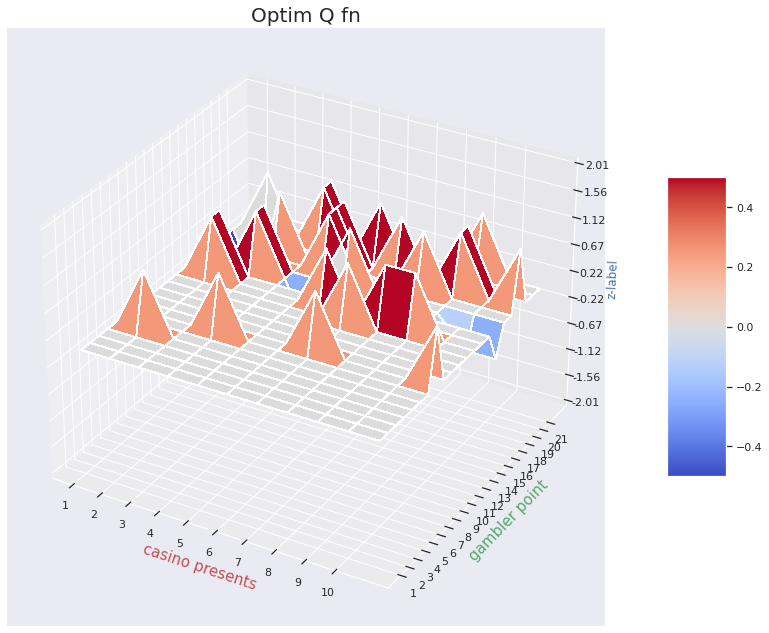

In [31]:
# visualizing Q, when Q =  100 plays
visualize_Q(num_events=100)

/tmp/ipykernel_25427/4256009631.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


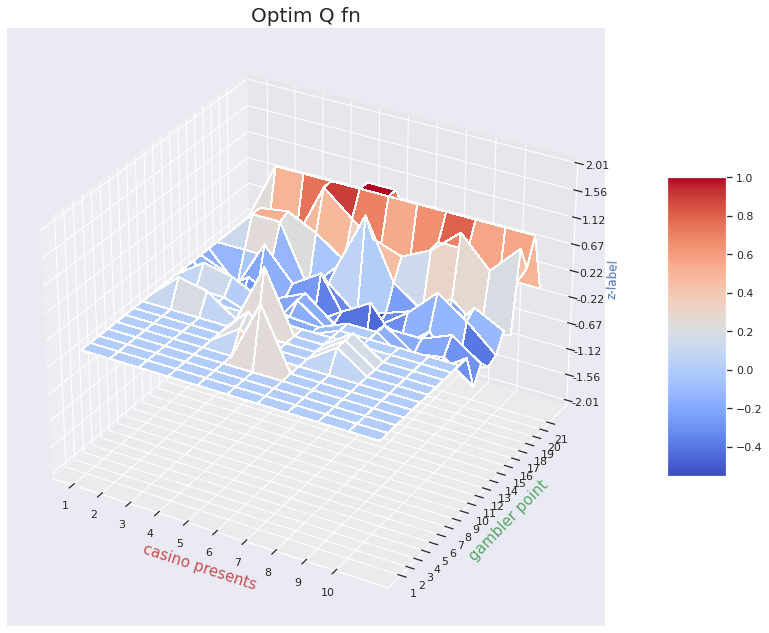

In [32]:
# visualizing Q, when Q = 1000 plays
visualize_Q(num_events=1000)

/tmp/ipykernel_25427/4256009631.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


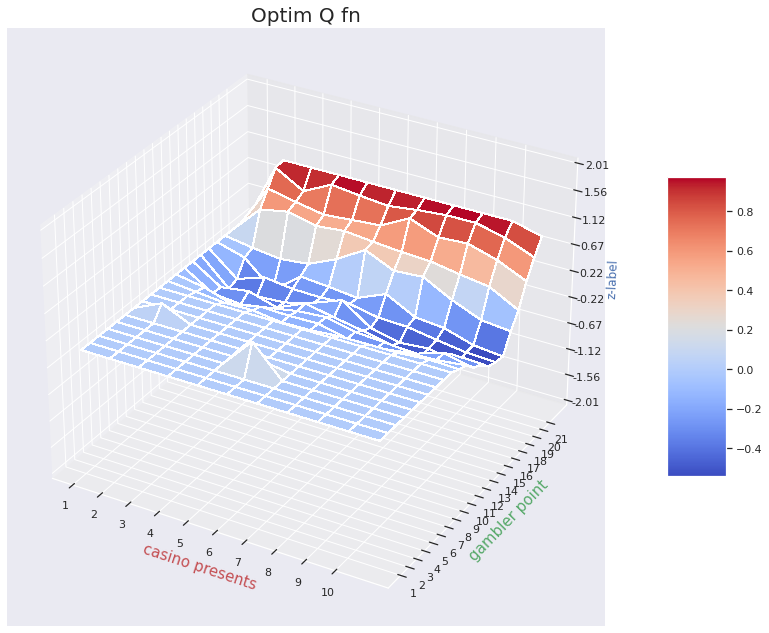

In [33]:
# visualizing Q, when Q = 10000 plays
visualize_Q(num_events=10_000)

/tmp/ipykernel_25427/4256009631.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


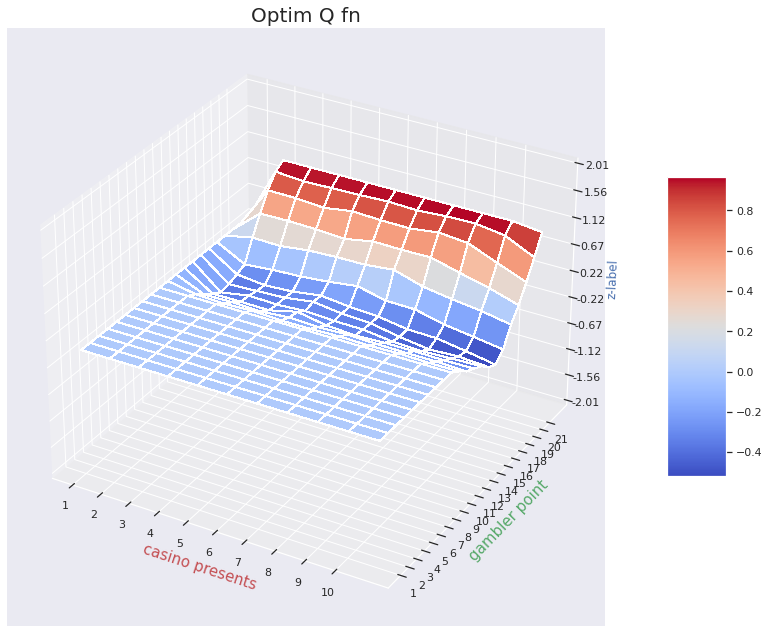

In [34]:
# visualizing Q, when Q = 100 000 games
visualize_Q(num_events=100_000)

/tmp/ipykernel_25427/4256009631.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


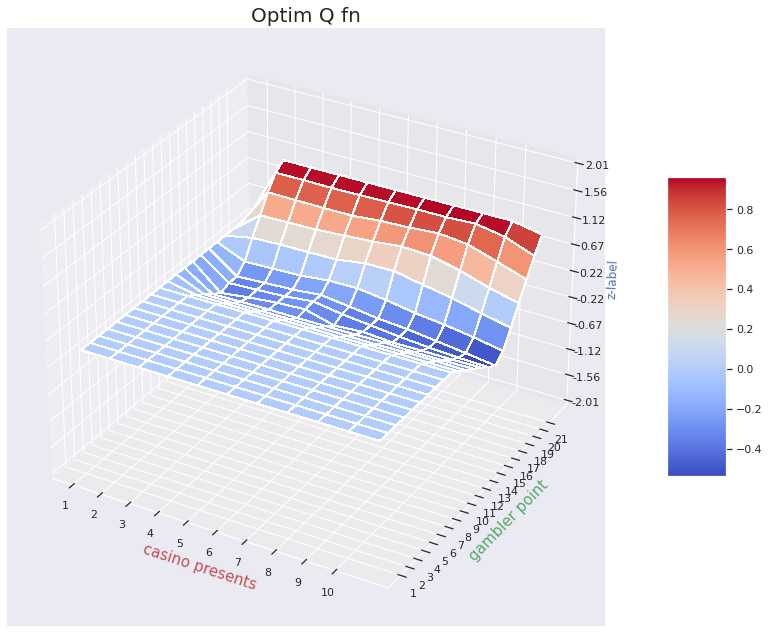

In [35]:
# visualizing Q, when Q =  1 000 000 games
visualize_Q(num_events=1_000000)

##Remarks: 

One could see that the Q number variation diminishes and is more "even" as the amount  played increases. The variation is so significant at 100 plays that  one could  see peaks on the plot.

## Developing optimal moves from Monte_Carlo_Control

In [36]:
def demonstrate_policy_optim(num_events):
    monteCar = Monte_Carlo_Control(e_c=100, num_events=num_events)
    monteCar.determine_q_fn()
    df = pd.DataFrame(columns=["casino_presents", "gambler_point", "smart_play"])
    positions = list(monteCar.Q.keys())
    for i in range(len(positions) - casino_point_high*2):
        smart_play = max(monteCar.Q[positions[i]], key=monteCar.Q[positions[i]].get)
        df.loc[i] = (positions[i][0], positions[i][1], smart_play)

    data_frame_key = df.pivot("gambler_point", "casino_presents", "smart_play")
    return data_frame_key

In [37]:
# perfect moves got from  1 00 plays
demonstrate_policy_optim(num_events=100)

casino_presents,1,2,3,4,5,6,7,8,9,10,11
gambler_point,,,,,,,,,,,
1,take,take,take,take,take,take,take,take,take,take,take
2,take,take,take,take,take,take,take,take,take,take,take
3,take,take,take,take,take,take,take,take,take,take,take
4,take,take,take,take,take,take,take,take,take,take,take
5,take,take,take,take,take,take,take,take,take,take,take
6,take,take,take,untake,take,take,take,take,take,take,untake
7,take,take,take,take,take,take,take,take,take,take,take
8,take,take,take,take,take,take,take,take,untake,take,take
9,take,untake,take,take,take,take,take,take,take,untake,take


In [38]:
# perfect moves got from  1000 plays
demonstrate_policy_optim(num_events=10_00)

casino_presents,1,2,3,4,5,6,7,8,9,10,11
gambler_point,,,,,,,,,,,
1,take,take,take,take,take,take,take,take,take,take,take
2,take,take,take,take,take,take,take,take,take,take,take
3,take,take,take,take,take,take,take,take,take,take,take
4,take,take,take,take,take,take,take,take,take,take,take
5,take,untake,take,take,take,take,untake,take,take,untake,take
6,take,take,untake,take,untake,take,take,take,take,take,take
7,take,take,take,untake,take,take,take,take,take,untake,take
8,take,take,take,take,take,take,take,untake,take,take,untake
9,take,untake,untake,untake,untake,untake,take,take,take,take,take


In [39]:
# perfect moves got from  1 00 00 plays
demonstrate_policy_optim(num_events=10000)

casino_presents,1,2,3,4,5,6,7,8,9,10,11
gambler_point,,,,,,,,,,,
1,take,take,take,take,take,take,take,take,take,take,take
2,take,take,take,take,take,take,take,take,take,take,take
3,take,take,take,take,take,take,take,take,take,take,take
4,take,take,untake,untake,untake,take,take,take,take,take,take
5,take,take,take,take,take,take,take,take,take,take,take
6,take,take,take,take,take,take,take,take,take,take,take
7,take,take,take,take,take,take,take,take,take,take,take
8,take,take,take,take,take,take,take,take,take,take,take
9,take,take,take,take,take,take,take,take,take,take,take


In [40]:
# perfect moves got from  1000 00 plays
demonstrate_policy_optim(num_events=1_00000)

casino_presents,1,2,3,4,5,6,7,8,9,10,11
gambler_point,,,,,,,,,,,
1,take,take,take,take,take,take,take,take,take,take,take
2,take,take,take,take,take,take,take,take,take,take,take
3,take,take,take,take,take,take,take,take,take,take,take
4,take,take,take,take,take,untake,take,take,take,take,take
5,take,take,take,take,take,take,take,take,take,take,take
6,take,take,take,take,take,take,take,take,take,take,take
7,take,take,take,take,take,take,take,take,take,take,take
8,take,take,take,take,take,take,take,take,take,take,take
9,take,take,take,take,take,take,take,take,take,take,take
